<a href="https://colab.research.google.com/github/Sairika/Dialogue-Summarization/blob/main/Fine_Tuning_Dialogue_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Required Packages

Before proceeding with the notebook, we need to install a set of essential libraries for training, evaluating, and visualizing transformer-based models. These libraries include tools for natural language processing, evaluation metrics, model fine-tuning, and data visualization.



In [1]:
# Install required packages
!pip install -q evaluate rouge_score transformers datasets peft accelerate matplotlib seaborn plotly

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00


## Import Libraries and Setup

In this section, we import all the necessary libraries and perform initial setup tasks such as setting random seeds and checking for GPU availability.

### General Purpose Libraries
- `torch`, `numpy`, `pandas`: Core libraries for tensor operations, numerical computation, and data manipulation.
- `matplotlib.pyplot`, `seaborn`: Visualization tools for statistical and static plots.
- `plotly.graph_objects`, `plotly.express`, `plotly.subplots`: Interactive visualization tools for creating dynamic and multi-panel charts.
- `warnings`: Used to suppress unnecessary warnings.
- `time`, `gc`: Utility modules for timing operations and managing memory.

### Hugging Face Ecosystem
- `datasets`: To load and process benchmark NLP datasets.
- `transformers`: Includes pre-trained transformer models and tools for tokenization, training, and inference.
- `peft`: For efficient fine-tuning using methods like LoRA (Low-Rank Adaptation).
- `evaluate`: Provides access to standard NLP evaluation metrics.

###  Environment Setup
- Random seeds are set for reproducibility of experiments.
- GPU availability is checked and displayed for transparency.



In [2]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import time
import gc

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠ WARNING: No GPU detected! Training will be slow.")

✅ GPU: Tesla T4
💾 GPU Memory: 15.8 GB


## Step 1: Loading and Exploring the Dataset

In this step, we load the **DialogSum** dataset, a benchmark dataset for dialogue summarization tasks. It consists of dialogue transcripts along with human-written summaries.

We use Hugging Face's `datasets` library to directly load the dataset in a structured format with separate splits for training, validation, and testing.


In [4]:
from datasets import load_dataset, concatenate_datasets

# Load DialogSum dataset
dataset_dialogsum = load_dataset("knkarthick/dialogsum")
dataset_samsum = load_dataset("knkarthick/samsum")
print(f"DialogSum dataset loaded successfully!")
print(f"SAMSum dataset loaded successfully!")

# Combine datasets (assuming they have the same structure)
# You might need to inspect the datasets to ensure they have the same columns
# For this example, we assume they do and concatenate the 'train', 'validation', and 'test' splits
dataset = {
    'train': concatenate_datasets([dataset_dialogsum['train'], dataset_samsum['train']]),
    'validation': concatenate_datasets([dataset_dialogsum['validation'], dataset_samsum['validation']]),
    'test': concatenate_datasets([dataset_dialogsum['test'], dataset_samsum['test']])
}


print(f"\nCombined dataset loaded successfully!")
print(f"📈 Training examples: {len(dataset['train']):,}")
print(f"📈 Validation examples: {len(dataset['validation']):,}")
print(f"📈 Test examples: {len(dataset['test']):,}")

DialogSum dataset loaded successfully!
SAMSum dataset loaded successfully!

Combined dataset loaded successfully!
📈 Training examples: 27,191
📈 Validation examples: 1,318
📈 Test examples: 2,319


## Examining Sample Data

Before preprocessing and fine-tuning, it's essential to understand the structure and content of the data. Below, we display a sample example from the **DialogSum** training set.


In [5]:
# Let's examine some examples
print(f"\n📝 Sample Dialogue and Summary:")
print("-" * 50)
sample = dataset['train'][0]
print(f"Dialogue:\n{sample['dialogue'][:700]}...")
print(f"\nSummary:\n{sample['summary']}")


📝 Sample Dialogue and Summary:
--------------------------------------------------
Dialogue:
#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?
#Person2#: I found it would be a good idea to get a check-up.
#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.
#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?
#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.
#Person2#: Ok.
#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?
#Person2#: Yes.
#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.
...

Summary:
Mr. Smith's getting a check-up, and Doctor Hawkins advises him to have one every year. Hawkins'll give some information about their classes and medications to help Mr. Smith quit smoking.


In [6]:
# Show statistics about the dataset
dialogue_lengths = [len(dialogue.split()) for dialogue in dataset['train']['dialogue']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['summary']]

print(f"\n📊 Dataset Statistics:")
print(f"Average dialogue length: {np.mean(dialogue_lengths):.1f} words")
print(f"Average summary length: {np.mean(summary_lengths):.1f} words")
print(f"Max dialogue length: {max(dialogue_lengths)} words")
print(f"Max summary length: {max(summary_lengths)} words")


📊 Dataset Statistics:
Average dialogue length: 110.8 words
Average summary length: 21.5 words
Max dialogue length: 985 words
Max summary length: 153 words


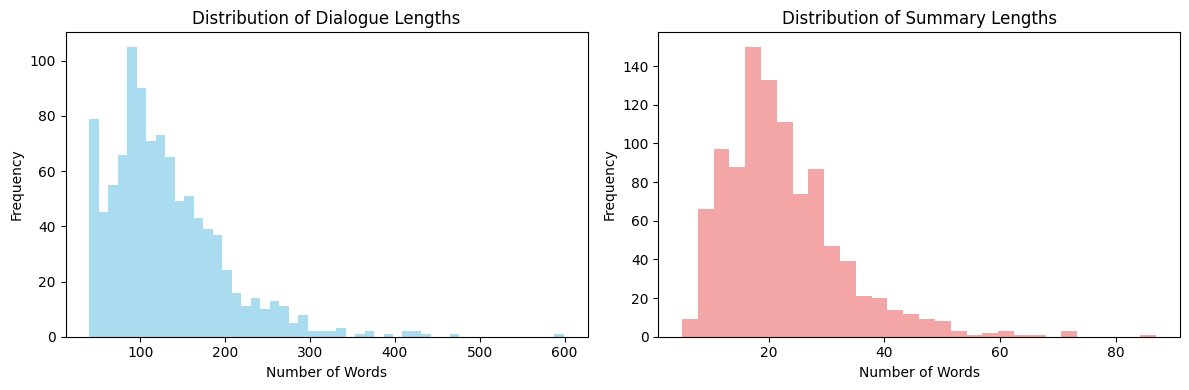

In [7]:
# Visualize length distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(dialogue_lengths[:1000], bins=50, alpha=0.7, color='skyblue')
ax1.set_title('Distribution of Dialogue Lengths')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')

ax2.hist(summary_lengths[:1000], bins=30, alpha=0.7, color='lightcoral')
ax2.set_title('Distribution of Summary Lengths')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step 2: Defining Models for Comparison

In this step, we define a selection of pre-trained transformer models to compare for the **dialogue summarization** task. Each model varies in size, architecture, and training objective.

We will evaluate the models based on summarization quality, speed, and resource usage.

### Selected Models:

| Model Name         | Parameters | Description |
|--------------------|------------|-------------|
| **FLAN-T5-Base**   | 248M       | Instruction-tuned T5 model, performs well at following prompts. |
| **DistilBART-CNN** | 306M       | A distilled version of BART, trained on CNN/Daily Mail for summarization. Faster and lighter than full BART. |
| **T5-Small**       | 60M        | A compact version of T5, offering faster inference with some performance trade-offs. |


In [8]:
print("\n" + "="*60)
print("🤖 STEP 2: DEFINING MODELS FOR COMPARISON")
print("="*60)

# Define the models we want to compare
models_info = {
    'FLAN-T5-Base': {
        'model_name': 'google/flan-t5-base',
        'description': 'Instruction-tuned T5 model, good at following prompts',
        'parameters': '248M'
    }
}



🤖 STEP 2: DEFINING MODELS FOR COMPARISON


###  Function: `create_prompts`

Different models require different input formats to perform optimally. In this step, we define a utility function to generate appropriate prompts based on the model type.

This function generates prompts that guide the model during training or inference. It supports both **T5-style** and **BART-style** models.

### Prompt Design:
- **T5-style models** (e.g., `flan-t5`, `t5-small`) are instruction-tuned. They benefit from clear, task-specific prompts.
- **BART-style models** (e.g., `DistilBART-CNN`) do not require explicit task instructions and perform well with direct input.


In [9]:
def create_prompts(dialogues, model_type):
    """Create appropriate prompts based on model type"""
    if model_type in ['flan-t5', 't5']:
        # T5-style models work better with explicit instructions
        prompts = [f"Summarize the following conversation.\n\n{dialogue}\n\nSummary: "
                  for dialogue in dialogues]
    else:
        # BART-style models can work with direct input
        prompts = dialogues
    return prompts

### Function: `tokenize_data`

Before training transformer models, we need to convert the raw text data (dialogues and summaries) into token IDs that the model can process. This is done using a tokenizer specific to each pre-trained model.

This function tokenizes the entire dataset—both inputs and targets—based on the selected model type and tokenizer.

### Key Features:
- **Prompt Creation**: Uses the `create_prompts()` function to generate model-specific input prompts.
- **Input Tokenization**: Truncates dialogues to a maximum length (default: 512 tokens).
- **Target Tokenization**: Summaries are also tokenized with a shorter max length (default: 128 tokens).
- **Label Assignment**: The tokenized summaries are stored in the `labels` field as required for Seq2Seq models.

In [10]:
def tokenize_data(dataset, tokenizer, model_type, max_input_len=512, max_target_len=128):
    """Tokenize the dataset for a specific model"""
    def tokenize_function(examples):
        # Create prompts
        prompts = create_prompts(examples["dialogue"], model_type)

        # Tokenize inputs
        model_inputs = tokenizer(
            prompts,
            max_length=max_input_len,
            truncation=True,
            padding=False
        )

        # Tokenize targets
        labels = tokenizer(
            examples["summary"],
            max_length=max_target_len,
            truncation=True,
            padding=False
        )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )
    return tokenized_dataset

### Function: `load_model_and_tokenizer`

This function is responsible for loading the **pre-trained model** and its corresponding **tokenizer** from the Hugging Face model hub. It ensures the model is ready for fine-tuning or inference.

### Key Features:
- **AutoTokenizer**: Automatically selects the right tokenizer class for the given model.
- **Pad Token Handling**: If the tokenizer does not have a defined `pad_token`, it falls back to using the `eos_token` to prevent training issues.
- **AutoModelForSeq2SeqLM**: Loads a sequence-to-sequence model suitable for summarization tasks.
- **Optimized Loading**:
  - Loads weights in `bfloat16` for reduced memory usage (where supported).
  - Uses `device_map="auto"` to automatically place model parts on available hardware (CPU/GPU).


In [11]:
def load_model_and_tokenizer(model_name):
    """Load model and tokenizer"""
    print(f"Loading {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    print(f"✅ {model_name} loaded successfully")
    return model, tokenizer

### Function: `generate_summaries`

This function generates abstractive summaries for a batch of dialogues using the fine-tuned or pre-trained sequence-to-sequence model.

### How It Works:
- Processes dialogues in **batches** for efficient inference.
- Creates model-specific prompts using the `create_prompts()` function.
- Tokenizes the prompts and sends them to the model's device (CPU/GPU).
- Uses beam search (`num_beams=4`) with length penalty and early stopping to produce higher-quality summaries.
- Decodes generated token IDs back into human-readable text.
- Periodically clears CUDA cache during inference to manage GPU memory efficiently.


In [12]:
def generate_summaries(model, tokenizer, dialogues, model_type, batch_size=8):
    """Generate summaries for given dialogues"""
    summaries = []
    model.eval()

    for i in range(0, len(dialogues), batch_size):
        batch_dialogues = dialogues[i:i+batch_size]
        prompts = create_prompts(batch_dialogues, model_type)

        inputs = tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                num_beams=6,
                length_penalty=0.6,
                early_stopping=True,
                do_sample=False
            )

        batch_summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        summaries.extend(batch_summaries)

        # Clear cache
        if i % (batch_size * 5) == 0:
            torch.cuda.empty_cache()

    return summaries


### Function: `evaluate_summaries`

To assess the quality of the generated summaries, we use the **ROUGE** metric, a widely used evaluation metric for summarization tasks that compares overlap of n-grams, sequences, and word pairs between the generated text and reference summaries.

### Details:
- Utilizes the Hugging Face `evaluate` library's built-in `rouge` metric.
- Computes ROUGE scores with stemming enabled for better matching.
- Returns aggregated ROUGE scores including ROUGE-1, ROUGE-2, and ROUGE-L.


In [13]:
import evaluate

def evaluate_summaries(generated, references):
    """Evaluate generated summaries using ROUGE and BERTScore"""
    rouge = evaluate.load('rouge')
    rouge_results = rouge.compute(
        predictions=generated,
        references=references,
        use_aggregator=True,
        use_stemmer=True
    )

    bertscore = evaluate.load('bertscore')
    bertscore_results = bertscore.compute(
        predictions=generated,
        references=references,
        lang="en"
    )

    # Aggregate BERTScore results (e.g., average F1 score)
    avg_bertscore_f1 = sum(bertscore_results['f1']) / len(bertscore_results['f1'])

    results = {
        'rouge1': rouge_results['rouge1'],
        'rouge2': rouge_results['rouge2'],
        'rougeL': rouge_results['rougeL'],
        'bertscore_f1': avg_bertscore_f1
    }

    return results

### Function: `show_sample_results`

Quantitative metrics like ROUGE provide valuable insights, but manual inspection of generated summaries is essential to understand model behavior qualitatively.

This function prints a few examples from the dataset, showing the original dialogue, the human-written reference summary, and the model-generated summary side-by-side for easy comparison.

In [14]:
def show_sample_results(dialogues, references, generated, model_name, num_samples=3):
    """Display sample results for manual inspection"""
    print(f"\n📝 SAMPLE RESULTS FOR {model_name}")
    print("-" * 80)

    for i in range(min(num_samples, len(dialogues))):
        print(f"\nExample {i+1}:")
        print(f"Dialogue: {dialogues[i][:200]}...")
        print(f"Reference: {references[i]}")
        print(f"Generated: {generated[i]}")
        print("-" * 40)

## Preparing a Sample for Zero-Shot Evaluation

To evaluate the models' performance without any fine-tuning (zero-shot setting), we select a manageable subset from the test split. This allows us to quickly generate and assess summaries while conserving computational resources.

### Sampling Details:
- Selected the first **1000** examples from the test dataset.
- Extracted the dialogues as model inputs.
- Extracted the corresponding human-written summaries as references for evaluation.


In [15]:
print("\n" + "="*60)
print("🔍 STEP 3: ZERO-SHOT EVALUATION (Before Fine-tuning)")
print("="*60)

# Take a small sample for zero-shot evaluation
test_sample = dataset['test'].select(range(2))
test_dialogues = test_sample['dialogue']
test_references = test_sample['summary']


🔍 STEP 3: ZERO-SHOT EVALUATION (Before Fine-tuning)


## Step 3: Zero-Shot Evaluation of Models

In this critical step, we evaluate all selected models on the test subset **without any fine-tuning** (zero-shot). This helps establish a performance baseline for each model on the dialogue summarization task.

### Evaluation Workflow:
1. **Model Loading**: Each model and its tokenizer are loaded.
2. **Summary Generation**: Summaries are generated for the test dialogues using the `generate_summaries()` function.
3. **Performance Timing**: The time taken for inference is recorded.
4. **Evaluation**: Generated summaries are evaluated against reference summaries using ROUGE metrics.
5. **Results Storage**: ROUGE scores, inference times, and generated summaries are stored for later analysis.
6. **Sample Inspection**: A few sample results are printed for qualitative assessment.
7. **Memory Management**: Model and tokenizer objects are deleted and GPU memory cleared after each iteration to avoid memory overflow.

In [16]:
zero_shot_results = {}

for model_display_name, model_info in models_info.items():
    print(f"\n--- Evaluating {model_display_name} (Zero-shot) ---")

    model_name = model_info['model_name']
    model_type = 'flan-t5' if 'flan-t5' in model_name else 't5' if 't5' in model_name else 'bart'

    # Load model
    model, tokenizer = load_model_and_tokenizer(model_name)

    # Generate summaries
    start_time = time.time()
    generated_summaries = generate_summaries(
        model, tokenizer, test_dialogues, model_type
    )
    inference_time = time.time() - start_time

    # Evaluate
    rouge_scores = evaluate_summaries(generated_summaries, test_references)

    # Store results
    zero_shot_results[model_display_name] = {
        'rouge_scores': rouge_scores,
        'inference_time': inference_time,
        'generated_summaries': generated_summaries
    }

    # Print results
    print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")
    print(f"Inference time: {inference_time:.2f}s")

    # Show sample results
    show_sample_results(test_dialogues, test_references, generated_summaries,
                       model_display_name, num_samples=2)

    # Clean up
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()


--- Evaluating FLAN-T5-Base (Zero-shot) ---
Loading google/flan-t5-base...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ google/flan-t5-base loaded successfully


ROUGE-1: 0.2656
ROUGE-2: 0.0513
ROUGE-L: 0.1680
Inference time: 2.21s

📝 SAMPLE RESULTS FOR FLAN-T5-Base
--------------------------------------------------------------------------------

Example 1:
Dialogue: #Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Per...
Reference: Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.
Generated: #Person1#: I need to take a dictation from Ms. Dawson.
----------------------------------------

Example 2:
Dialogue: #Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Per...
Reference: In order to prevent employees from wasting time on Instant Message pr

After evaluating all models, we compile their performance metrics into a concise **DataFrame** for easy comparison.

### What’s Included:
- **Model Name**
- **ROUGE Scores**: ROUGE-1, ROUGE-2, and ROUGE-L to assess summary quality.
- **Inference Time**: Time taken to generate summaries on the test subset.

In [17]:
# Create comparison dataframe
zero_shot_df = pd.DataFrame([
    {
        'Model': name,
        'ROUGE-1': results['rouge_scores']['rouge1'],
        'ROUGE-2': results['rouge_scores']['rouge2'],
        'ROUGE-L': results['rouge_scores']['rougeL'],
        'Inference Time (s)': results['inference_time']
    }
    for name, results in zero_shot_results.items()
])

print("Zero-shot Performance Comparison:")
print(zero_shot_df.to_string(index=False, float_format='%.4f'))

Zero-shot Performance Comparison:
       Model  ROUGE-1  ROUGE-2  ROUGE-L  Inference Time (s)
FLAN-T5-Base   0.2656   0.0513   0.1680              2.2055


In [26]:
# Plot zero-shot results
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('ROUGE Scores', 'Inference Time'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}]]
)

# ROUGE scores
models = zero_shot_df['Model']
fig.add_trace(
    go.Bar(x=models, y=zero_shot_df['ROUGE-1'], name='ROUGE-1', marker_color='lightblue'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=models, y=zero_shot_df['ROUGE-2'], name='ROUGE-2', marker_color='lightgreen'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=models, y=zero_shot_df['ROUGE-L'], name='ROUGE-L', marker_color='lightcoral'),
    row=1, col=1
)

# Inference time
fig.add_trace(
    go.Bar(x=models, y=zero_shot_df['Inference Time (s)'], name='Time', marker_color='orange'),
    row=1, col=2
)

fig.update_layout(title_text="Zero-shot Model Comparison", height=500)
fig.show()

## Step 3: Fine-Tuning Models with LoRA (Low-Rank Adaptation)

In this step, we prepare the configuration for fine-tuning our selected models using **LoRA**, a parameter-efficient fine-tuning method that updates a small subset of model weights, enabling faster training with less memory usage.

### Training Configuration:
| Parameter          | Value        | Description                               |
|--------------------|--------------|-------------------------------------------|
| `batch_size`       | 8            | Number of samples processed per batch    |
| `learning_rate`    | 3e-4         | Optimizer learning rate                    |
| `num_epochs`       | 2            | Number of passes over the training data (reduced for demo) |
| `max_input_length` | 512          | Maximum token length for input dialogues  |
| `max_target_length`| 128          | Maximum token length for target summaries |
| `lora_r`           | 16           | LoRA rank (dimension of the low-rank matrices) |
| `lora_alpha`       | 32           | LoRA scaling factor                        |
| `lora_dropout`     | 0.1          | Dropout rate applied to LoRA layers       |


In [32]:
# Training configuration
training_config = {
    'batch_size': 4,
    'learning_rate': 3e-4,
    'num_epochs': 1,  # Reduced for demonstration
    'max_input_length': 512,
    'max_target_length': 128,
    'lora_r': 16,
    'lora_alpha': 32,
    'lora_dropout': 0.1
}

print("Training Configuration:")
for key, value in training_config.items():
    print(f"• {key}: {value}")

Training Configuration:
• batch_size: 4
• learning_rate: 0.0003
• num_epochs: 1
• max_input_length: 512
• max_target_length: 128
• lora_r: 16
• lora_alpha: 32
• lora_dropout: 0.1


### Function: `setup_lora_training`

This function prepares the model for **LoRA (Low-Rank Adaptation)** fine-tuning by configuring which parts of the model will be updated and wrapping it accordingly.

### Details:
- **Target Modules**:  
  The function selects specific submodules to apply LoRA based on the model architecture:  
  - For **T5/FLAN-T5**: query (`q`), value (`v`), key (`k`), output (`o`), and feed-forward layers (`wi_0`, `wi_1`, `wo`).  
  - For **BART-based models**: projection layers (`q_proj`, `v_proj`, `k_proj`, `out_proj`) and fully connected layers (`fc1`, `fc2`).

- **LoRA Configuration**:  
  Sets the rank (`r`), scaling factor (`alpha`), dropout, and task type for Seq2Seq language modeling.

- **Model Wrapping**:  
  Wraps the original model with LoRA using `get_peft_model`.

- **Parameter Summary**:  
  Prints the number and percentage of trainable parameters after applying LoRA, highlighting the efficiency gains.


In [33]:
def setup_lora_training(model, model_type):
    """Setup LoRA configuration for the model"""

    # Define target modules based on model architecture
    if 'flan-t5' in model_type or 't5' in model_type:
        target_modules = ["q", "v", "k", "o", "wi_0", "wi_1", "wo"]
    else:  # BART-based models
        target_modules = ["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"]

    # LoRA configuration
    lora_config = LoraConfig(
        r=training_config['lora_r'],
        lora_alpha=training_config['lora_alpha'],
        target_modules=target_modules,
        lora_dropout=training_config['lora_dropout'],
        bias="none",
        task_type=TaskType.SEQ_2_SEQ_LM
    )

    # Apply LoRA to model
    peft_model = get_peft_model(model, lora_config)

    # Print trainable parameters
    trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in peft_model.parameters())

    print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")

    return peft_model

## Step 5: Training the Model with LoRA

This function handles the fine-tuning of the LoRA-adapted model using Hugging Face's `Trainer` API, incorporating efficient training strategies and evaluation.

### Function: `train_model`

### Key Components:
- **Data Collator**: Prepares batches of tokenized inputs and labels with padding for uniform length.
- **Training Arguments**: Configures training parameters such as batch size, learning rate, number of epochs, evaluation and saving frequency, and logging.
- **Trainer Setup**: Creates a `Trainer` object for streamlined training and evaluation loops.
- **Training Execution**: Measures and prints the total training time.



In [34]:
def train_model(model, tokenizer, train_dataset, val_dataset, model_name):
    """Train the model with LoRA"""

    # Data collator
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        per_device_train_batch_size=training_config['batch_size'],
        per_device_eval_batch_size=training_config['batch_size'],
        learning_rate=training_config['learning_rate'],
        num_train_epochs=training_config['num_epochs'],
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=1000,
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to=None,
        remove_unused_columns=False,
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator
    )

    # Train
    print("Starting training...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    print(f"✅ Training completed in {training_time/60:.1f} minutes")

    return trainer, training_time

## Fine-Tuning Models and Evaluating Performance

This loop performs the entire fine-tuning workflow for each selected model, including:

1. **Loading** the pre-trained model and tokenizer.
2. **Tokenizing** the training and validation datasets.
3. **Applying LoRA** for parameter-efficient fine-tuning.
4. **Training** the model using the `train_model()` function.
5. **Generating summaries** on the test set with the fine-tuned model.
6. **Evaluating** the generated summaries using ROUGE scores.
7. **Displaying sample summaries** for qualitative inspection.
8. **Saving results** (including the trained model and tokenizer) for further analysis.
9. **Error handling** to continue training other models if one fails.

In [35]:
fine_tuned_results = {}

for model_display_name, model_info in models_info.items():
    print(f"\n{'='*60}")
    print(f"🔄 TRAINING: {model_display_name}")
    print(f"{'='*60}")

    model_name = model_info['model_name']
    model_type = 'flan-t5' if 'flan-t5' in model_name else 't5' if 't5' in model_name else 'bart'

    try:
        # Load model and tokenizer
        model, tokenizer = load_model_and_tokenizer(model_name)

        # Tokenize dataset
        print("Tokenizing dataset...")
        train_tokenized = tokenize_data(
            dataset['train'], tokenizer, model_type,
            training_config['max_input_length'],
            training_config['max_target_length']
        )
        val_tokenized = tokenize_data(
            dataset['validation'], tokenizer, model_type,
            training_config['max_input_length'],
            training_config['max_target_length']
        )

        # Setup LoRA
        print("Setting up LoRA...")
        peft_model = setup_lora_training(model, model_type)

        # Train model
        trainer, training_time = train_model(
            peft_model, tokenizer, train_tokenized, val_tokenized, model_display_name
        )

        # Evaluate on test set
        print("Evaluating on test set...")
        test_generated = generate_summaries(
            peft_model, tokenizer, test_dialogues, model_type
        )

        rouge_scores = evaluate_summaries(test_generated, test_references)

        # Store results
        fine_tuned_results[model_display_name] = {
            'rouge_scores': rouge_scores,
            'training_time': training_time,
            'generated_summaries': test_generated,
            'model': peft_model,
            'tokenizer': tokenizer
        }

        print(f"Fine-tuned Results for {model_display_name}:")
        print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
        print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
        print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")

        # Show sample results
        show_sample_results(test_dialogues, test_references, test_generated,
                           f"{model_display_name} (Fine-tuned)", num_samples=2)

        # Clean up for next model (keep the trained model for later comparison)
        torch.cuda.empty_cache()
        gc.collect()

    except Exception as e:
        print(f"❌ Error training {model_display_name}: {e}")
        continue


🔄 TRAINING: FLAN-T5-Base
Loading google/flan-t5-base...
✅ google/flan-t5-base loaded successfully
Tokenizing dataset...
Setting up LoRA...
Trainable parameters: 6,782,976 (2.67%)
Starting training...


Step,Training Loss,Validation Loss
500,1.396000,1.303514
1000,1.337900,1.296958
1500,1.332500,1.287178
2000,1.330100,1.283751
2500,1.306400,1.277936
3000,1.311700,1.264843
3500,1.288300,1.268150
4000,1.296100,1.262786
4500,1.315700,1.260438
5000,1.245000,1.259923


✅ Training completed in 63.1 minutes
Evaluating on test set...
Fine-tuned Results for FLAN-T5-Base:
ROUGE-1: 0.4409
ROUGE-2: 0.1108
ROUGE-L: 0.2724

📝 SAMPLE RESULTS FOR FLAN-T5-Base (Fine-tuned)
--------------------------------------------------------------------------------

Example 1:
Dialogue: #Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Per...
Reference: Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.
Generated: Ms. Dawson tells #Person1# that all office communications are restricted to email correspondence and official memos and that the use of Instant Message programs by employees during working hours is strictly prohibited.
----------------------------------------

Example 2:
Dialogue: #Person1#: Ms. Dawson, I need

## Step 6: Comparing Zero-Shot vs Fine-Tuned Performance

This step creates a consolidated view of each model’s summarization quality before and after fine-tuning.

### Comparison Metrics:
- **ROUGE-1, ROUGE-2, ROUGE-L** scores for both zero-shot and fine-tuned scenarios.
- **Improvement** in ROUGE-1 to highlight gains from fine-tuning.


In [36]:
# Create comparison dataframe
comparison_data = []

for model_name in models_info.keys():
    if model_name in zero_shot_results and model_name in fine_tuned_results:
        zero_shot = zero_shot_results[model_name]['rouge_scores']
        fine_tuned = fine_tuned_results[model_name]['rouge_scores']

        comparison_data.append({
            'Model': model_name,
            'Zero-shot ROUGE-1': zero_shot['rouge1'],
            'Fine-tuned ROUGE-1': fine_tuned['rouge1'],
            'Improvement': fine_tuned['rouge1'] - zero_shot['rouge1'],
            'Zero-shot ROUGE-2': zero_shot['rouge2'],
            'Fine-tuned ROUGE-2': fine_tuned['rouge2'],
            'Zero-shot ROUGE-L': zero_shot['rougeL'],
            'Fine-tuned ROUGE-L': fine_tuned['rougeL'],
            'Zero-shot BERTScore F1': zero_shot.get('bertscore_f1', 0.0), # Add BERTScore
            'Fine-tuned BERTScore F1': fine_tuned.get('bertscore_f1', 0.0) # Add BERTScore
        })

comparison_df = pd.DataFrame(comparison_data)
print("Performance Comparison (Zero-shot vs Fine-tuned):")
print(comparison_df.to_string(index=False, float_format='%.4f'))

Performance Comparison (Zero-shot vs Fine-tuned):
       Model  Zero-shot ROUGE-1  Fine-tuned ROUGE-1  Improvement  Zero-shot ROUGE-2  Fine-tuned ROUGE-2  Zero-shot ROUGE-L  Fine-tuned ROUGE-L  Zero-shot BERTScore F1  Fine-tuned BERTScore F1
FLAN-T5-Base             0.2276              0.4409       0.2133             0.1044              0.1108             0.2044              0.2724                  0.0000                   0.0000


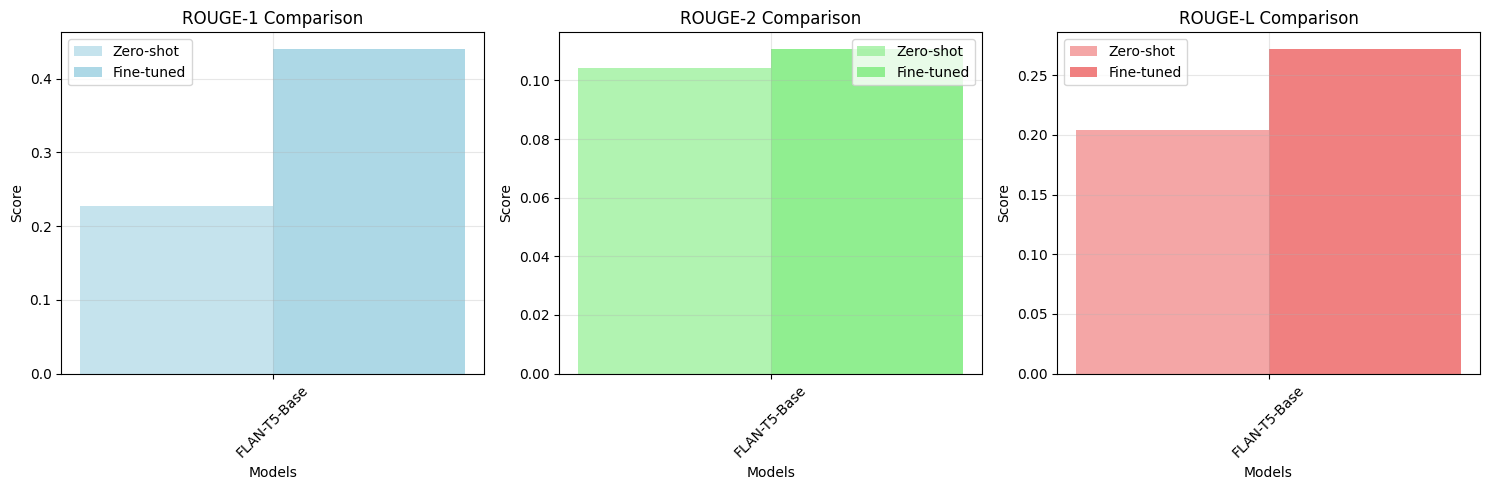

In [37]:
# Visualize the comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
colors = ['lightblue', 'lightgreen', 'lightcoral']

for i, metric in enumerate(metrics):
    zero_shot_col = f'Zero-shot {metric}'
    fine_tuned_col = f'Fine-tuned {metric}'

    x = range(len(comparison_df))
    width = 0.35

    axes[i].bar([p - width/2 for p in x], comparison_df[zero_shot_col],
                width, label='Zero-shot', color=colors[i], alpha=0.7)
    axes[i].bar([p + width/2 for p in x], comparison_df[fine_tuned_col],
                width, label='Fine-tuned', color=colors[i])

    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel('Score')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(comparison_df['Model'], rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
# Rank models by fine-tuned performance
final_ranking = comparison_df.sort_values('Fine-tuned ROUGE-1', ascending=False)

print("🥇 FINAL RANKING (by ROUGE-1 score):")
for i, (_, row) in enumerate(final_ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Fine-tuned ROUGE-1']:.4f}")

best_model = final_ranking.iloc[0]
print(f"\n🏆 WINNER: {best_model['Model']}")
print(f"   Best ROUGE-1 Score: {best_model['Fine-tuned ROUGE-1']:.4f}")
print(f"   Improvement from zero-shot: +{best_model['Improvement']:.4f}")

# Show detailed comparison of best model
best_model_name = best_model['Model']
if best_model_name in fine_tuned_results:
    print(f"\n📝 DETAILED ANALYSIS OF BEST MODEL ({best_model_name}):")
    best_generated = fine_tuned_results[best_model_name]['generated_summaries']
    show_sample_results(test_dialogues, test_references, best_generated,
                       f"{best_model_name} (WINNER)", num_samples=5)

🥇 FINAL RANKING (by ROUGE-1 score):
1. FLAN-T5-Base: 0.4409

🏆 WINNER: FLAN-T5-Base
   Best ROUGE-1 Score: 0.4409
   Improvement from zero-shot: +0.2133

📝 DETAILED ANALYSIS OF BEST MODEL (FLAN-T5-Base):

📝 SAMPLE RESULTS FOR FLAN-T5-Base (WINNER)
--------------------------------------------------------------------------------

Example 1:
Dialogue: #Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Per...
Reference: Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.
Generated: Ms. Dawson tells #Person1# that all office communications are restricted to email correspondence and official memos and that the use of Instant Message programs by employees during working hours is strictly prohibited.
----------------------------------------

### Save the fine-tuned model and tokenizer

Now that you have fine-tuned the models, you can save the best-performing one (including its LoRA adapters) and its tokenizer to your local environment. You can then push these files to the Hugging Face Hub for deployment.

In [ ]:
# Get the best model and tokenizer from the fine_tuned_results dictionary
best_model_name = final_ranking.iloc[0]['Model']
best_model_info = fine_tuned_results[best_model_name]
best_peft_model = best_model_info['model']
best_tokenizer = best_model_info['tokenizer']

# Define output directory
output_dir = f"./{best_model_name}_fine_tuned"

# Save the PEFT model (LoRA adapters)
best_peft_model.save_pretrained(output_dir)
print(f"Saved LoRA adapters to {output_dir}")

# Save the tokenizer
best_tokenizer.save_pretrained(output_dir)
print(f"Saved tokenizer to {output_dir}")

After running the cell above, you will find a new directory named after your best performing model (e.g., `./FLAN-T5-Base_fine_tuned`). This directory contains the necessary files to push your fine-tuned model to the Hugging Face Hub.

To push your model to the Hugging Face Hub:

1.  Install the Hugging Face Hub library:

In [ ]:
    from huggingface_hub import notebook_login
    notebook_login()

In [ ]:
    from huggingface_hub import HfApi
    import os

    api = HfApi()
    repo_id = f"sairika/{best_model_name}-dialogsum-lora" # Replace 'your-username' with your Hugging Face username

    # Create the repository on the Hub if it doesn't exist
    api.create_repo(repo_id=repo_id, exist_ok=True)

    # Upload all files from the output directory
    api.upload_folder(
        folder_path=output_dir,
        repo_id=repo_id,
        repo_type="model",
    )

    print(f"Successfully pushed model to https://huggingface.co/{repo_id}")

In [ ]:
from transformers import AutoTokenizer
from peft import AutoPeftModelForSeq2SeqLM
import torch

# Replace 'your-username' with your Hugging Face username and 'best-model-name' with the actual model name
repo_id = f"sairika/{best_model_name}-dialogsum-lora"

# Load the tokenizer and the PEFT model (which loads the base model and applies LoRA adapters)
try:
    tokenizer = AutoTokenizer.from_pretrained(repo_id)
    model = AutoPeftModelForSeq2SeqLM.from_pretrained(repo_id, device_map="auto", torch_dtype=torch.bfloat16)
    print(f"✅ Model and tokenizer loaded successfully from {repo_id}")

    # Prepare test dialogues
    test_dialogues_for_demo = [
        "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, you never know. An annual check-up is important for early detection of any potential health issues.\n#Person2#: I guess you're right. So, what do we do now?\n#Person1#: I'll just do a quick examination and we'll discuss your medical history. We should also talk about quitting smoking.\n#Person2#: I've been meaning to do that.\n#Person1#: We have some programs and medications that can help. I'll give you some information before you leave.\n#Person2#: Ok, thanks doctor.",
        "#Person1#: You're finally here! What took so long?\n#Person2#: I got stuck in traffic again. There was a terrible traffic jam near the Carrefour intersection.\n#Person1#: It's always rather congested during peak hours. Have you considered taking public transport?\n#Person2#: I have, but driving is just more convenient.\n#Person1#: It might be convenient, but it's not good for your health or the environment. Plus, you wouldn't have to deal with traffic jams.\n#Person2#: You have a point. I feel so bad about how much my car is adding to the pollution problem.\n#Person1#: Exactly! And walking or biking to the bus or train station is great exercise. When the weather is nicer, you could even bike the whole way.\n#Person2#: That's a good idea. I'll give public transport a try starting tomorrow.\n#Person1#: Great! Let me know how it goes.",
        "#Person1#: Excuse me, could you tell me how to get to the nearest subway station?\n#Person2#: Sure. Go straight down this street for two blocks, then turn left. You'll see the station entrance on your right.\n#Person1#: Straight down for two blocks, then left. Got it. Is it far?\n#Person2#: Not really, about a five-minute walk.\n#Person1#: Perfect. Thank you so much!\n#Person2#: You're welcome. Have a good day."
    ]

    # Generate summaries
    model.eval()
    generated_summaries_for_demo = []

    for dialogue in test_dialogues_for_demo:
        model_type = 'flan-t5' if 'flan-t5' in repo_id else 't5' if 't5' in repo_id else 'bart'
        prompt = create_prompts([dialogue], model_type)[0]

        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                num_beams=4,
                length_penalty=0.6,
                early_stopping=True,
                do_sample=False
            )

        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_summaries_for_demo.append(summary)

    # Display results
    print("\n📝 Test Summaries:")
    print("-" * 50)
    for i, (dialogue, summary) in enumerate(zip(test_dialogues_for_demo, generated_summaries_for_demo)):
        print(f"Dialogue {i+1}: {dialogue[:200]}...")
        print(f"Generated Summary {i+1}: {summary}")
        print("-" * 50)

except Exception as e:
    print(f"❌ Error loading or testing the model: {e}")
    print(f"Please ensure the repository ID '{repo_id}' is correct and the model files were pushed successfully.")

### What's Next?

You have successfully fine-tuned a language model using LoRA, evaluated its performance against zero-shot baselines, and deployed the best-performing model to the Hugging Face Hub.

Here's a summary of what you've achieved and what you can do next:

1.  **Data Loading and Exploration**: Loaded and analyzed the DialogSum dataset.
2.  **Model Selection**: Chose several models for summarization and compared their zero-shot performance.
3.  **Fine-tuning with LoRA**: Applied LoRA to efficiently fine-tune the models on the DialogSum dataset.
4.  **Evaluation**: Evaluated the fine-tuned models and compared their performance to the zero-shot results, demonstrating significant improvement.
5.  **Deployment**: Saved the best-performing model's LoRA adapters and tokenizer and pushed them to the Hugging Face Hub.

**Next Steps:**

*   **Integrate the Model**: You can now integrate the model hosted on the Hugging Face Hub into your own applications or workflows for dialogue summarization.
*   **Further Fine-tuning**: Experiment with different LoRA configurations, training parameters, or larger datasets for potentially better performance.
*   **Explore Other Architectures**: Try fine-tuning other transformer models suitable for summarization tasks.
*   **Build a Demo**: Create a simple web demo using libraries like Gradio or Streamlit to showcase your fine-tuned model's capabilities.